In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from datetime import date
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ideal-customer-analysis-personality-test/marketing_campaign.csv


# Dataset

**People:**
* ID: Customer's unique identifier
* Year_Birth: Customer's birth year
* Education: Customer's education level
* Marital_Status: Customer's marital status
* Income: Customer's yearly household income
* Kidhome: Number of children in customer's household
* Teenhome: Number of teenagers in customer's household
* Dt_Customer: Date of customer's enrollment with the company
* Recency: Number of days since customer's last purchase
* Complain: 1 if the customer complained in the last 2 years, 0 otherwise

**Products:**
* MntWines: Amount spent on wine in last 2 years
* MntFruits: Amount spent on fruits in last 2 years
* MntMeatProducts: Amount spent on meat in last 2 years
* MntFishProducts: Amount spent on fish in last 2 years
* MntSweetProducts: Amount spent on sweets in last 2 years
* MntGoldProds: Amount spent on gold in last 2 years

**Promotion:**
* NumDealsPurchases: Number of purchases made with a discount
* AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

**Place:**
* NumWebPurchases: Number of purchases made through the company’s website
* NumCatalogPurchases: Number of purchases made using a catalogue
* NumStorePurchases: Number of purchases made directly in stores
* NumWebVisitsMonth: Number of visits to company’s website in the last month

In [2]:
# Load dataset
df = pd.read_csv('/kaggle/input/ideal-customer-analysis-personality-test/marketing_campaign.csv', sep='\t', index_col=0)
df.head(10)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,3,11,0
965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,65,164,50,49,27,4,7,3,7,6,0,0,0,0,0,0,3,11,0
6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,3,11,0
4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,3,11,1


# Pre-processing

In [3]:
# Method to get a quick overview of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 5524 to 9405
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Dt_Customer          2240 non-null   object 
 7   Recency              2240 non-null   int64  
 8   MntWines             2240 non-null   int64  
 9   MntFruits            2240 non-null   int64  
 10  MntMeatProducts      2240 non-null   int64  
 11  MntFishProducts      2240 non-null   int64  
 12  MntSweetProducts     2240 non-null   int64  
 13  MntGoldProds         2240 non-null   int64  
 14  NumDealsPurchases    2240 non-null   int64  
 15  NumWebPurchases      2240 non-null 

In [4]:
# Check for missing values
df.isna().sum()

Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [5]:
# Drop NaN rows
df.dropna(axis=0, inplace=True)

In [6]:
# Method to count the frequency of unique values in the Education column 
df.Education.value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [7]:
# Create a binary variable from a categorical variable in the DataFrame,
# where the binary variable takes the value 1 if the person has at least graduated
# and 0 if it has a basic education
df['Education_Binary'] = df['Education']
df['Education_Binary'].replace('Graduation', 1, inplace=True)
df['Education_Binary'].replace('PhD', 1, inplace=True)
df['Education_Binary'].replace('Master', 1, inplace=True)
df['Education_Binary'].replace('2n Cycle', 1, inplace=True)
df['Education_Binary'].replace('Basic', 0, inplace=True)

In [8]:
# Method to count the frequency of unique values in the Marital_Status column 
df.Marital_Status.value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64

In [9]:
# Converting string values to numerical values
# Group data into 4 classes
df['Relationship_Status'] = df['Marital_Status']
df['Relationship_Status'].replace('Married', 1, inplace=True)
df['Relationship_Status'].replace('Together', 2, inplace=True)
df['Relationship_Status'].replace('Single', 0, inplace=True)
df['Relationship_Status'].replace('Divorced', 3, inplace=True)
df['Relationship_Status'].replace('Widow', 3, inplace=True)
df['Relationship_Status'].replace('Alone', 0, inplace=True)
df['Relationship_Status'].replace('Absurd', 3, inplace=True)
df['Relationship_Status'].replace('YOLO', 3, inplace=True)

In [10]:
# Calculate age based on the year of birth
current_year = 2023
df['Age'] = current_year - df.Year_Birth

In [11]:
# Visualise the first 5 rows of the dataset
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Education_Binary,Relationship_Status,Age
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,1,0,66
2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,1,0,69
4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,1,2,58
6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,1,2,39
5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,1,1,42


# Segmentation data

In [12]:
# Create a dataframe that contains specific columns
df_segmentation = df[['Age', 'Education_Binary', 'Relationship_Status', 'Income', 'Kidhome', 'Teenhome', 'Recency']]
df_segmentation.head()

,Age,Education_Binary,Relationship_Status,Income,Kidhome,Teenhome,Recency
ID,,,,,,,
5524,66,1,0,58138.0,0,0,58
2174,69,1,0,46344.0,1,1,38
4141,58,1,2,71613.0,0,0,26
6182,39,1,2,26646.0,1,0,26
5324,42,1,1,58293.0,1,0,94


## Data exploration

In [13]:
# Generate a statistical summary of the data 
df_segmentation.describe()

,Age,Education_Binary,Relationship_Status,Income,Kidhome,Teenhome,Recency
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,54.179603,0.975632,1.326264,52247.251354,0.441787,0.505415,49.012635
std,11.985554,0.154224,0.964169,25173.076661,0.536896,0.544181,28.948352
min,27.000000,0.000000,0.000000,1730.000000,0.000000,0.000000,0.000000
25%,46.000000,1.000000,1.000000,35303.000000,0.000000,0.000000,24.000000
50%,53.000000,1.000000,1.000000,51381.500000,0.000000,0.000000,49.000000
75%,64.000000,1.000000,2.000000,68522.000000,1.000000,1.000000,74.000000
max,130.000000,1.000000,3.000000,666666.000000,2.000000,2.000000,99.000000


In [14]:
# Calculate the correlation coefficient between every pair of variables
# in the dataframe, using Pearson's correlation coefficient by default 
df_segmentation.corr()

,Age,Education_Binary,Relationship_Status,Income,Kidhome,Teenhome,Recency
Age,1.000000,0.113986,0.179364,0.161791,-0.233615,0.350791,0.016295
Education_Binary,0.113986,1.000000,0.053491,0.200576,-0.055306,0.119919,0.003103
Relationship_Status,0.179364,0.053491,1.000000,0.040331,-0.044838,0.105479,0.008862
Income,0.161791,0.200576,0.040331,1.000000,-0.428669,0.019133,-0.003970
Kidhome,-0.233615,-0.055306,-0.044838,-0.428669,1.000000,-0.039869,0.011492
Teenhome,0.350791,0.119919,0.105479,0.019133,-0.039869,1.000000,0.013838
Recency,0.016295,0.003103,0.008862,-0.003970,0.011492,0.013838,1.000000


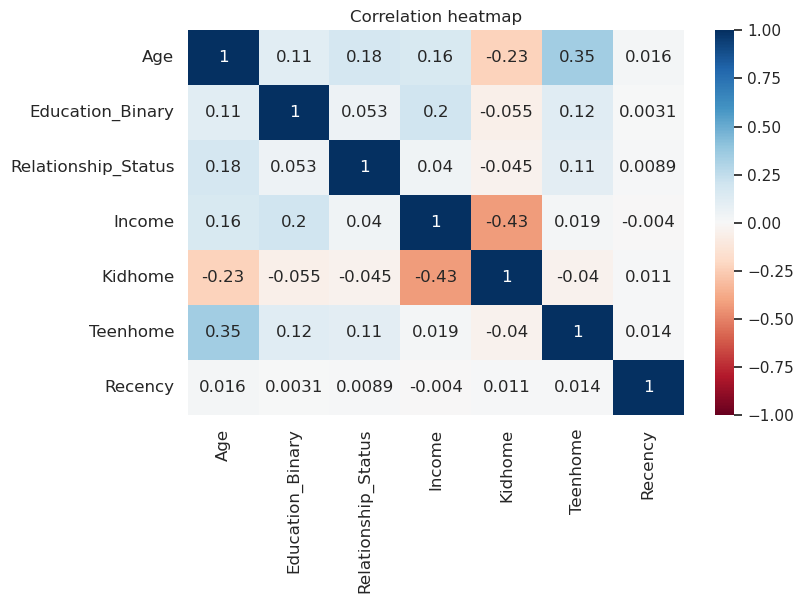

In [15]:
# Create a heatmap of the correlation matrix of the df_segmentation,
# which presumably contains variables related to customer segmentation
plt.figure(figsize = (8,5))
s = sns.heatmap(df_segmentation.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1,
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation heatmap')
plt.show()

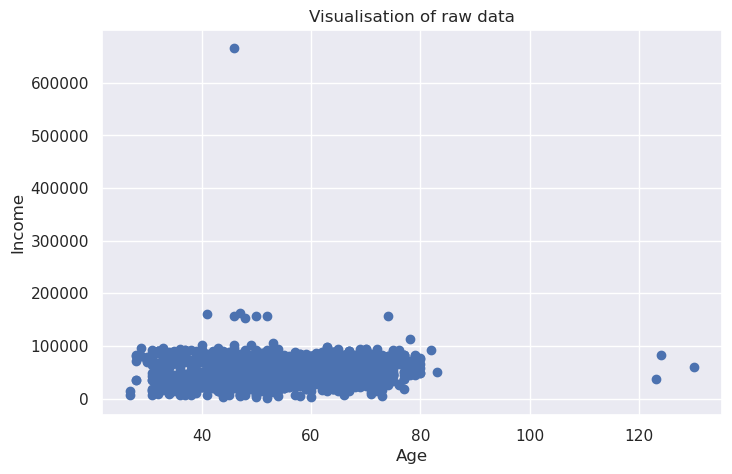

In [16]:
# Visualise raw data - age vs income
plt.figure(figsize = (8, 5))
plt.scatter(df_segmentation.iloc[:, 0], df_segmentation.iloc[:, 3])
plt.xlabel('Age')
plt.ylabel('Income')
plt.title('Visualisation of raw data')
plt.show()

In [17]:
# Performing a standardization operation on the df_segmentation
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(df_segmentation)

## Hierarchical Clustering

In [18]:
# Perform hierarchical clustering, where the data points are grouped
# based on their similarity to form a hierarchy of clusters.
# The ward method is a linkage criterion that minimizes the variance
# of the distances between the clusters being merged.
# This method is known for producing compact and spherical clusters.
hier_clust = linkage(segmentation_std, method = 'ward')

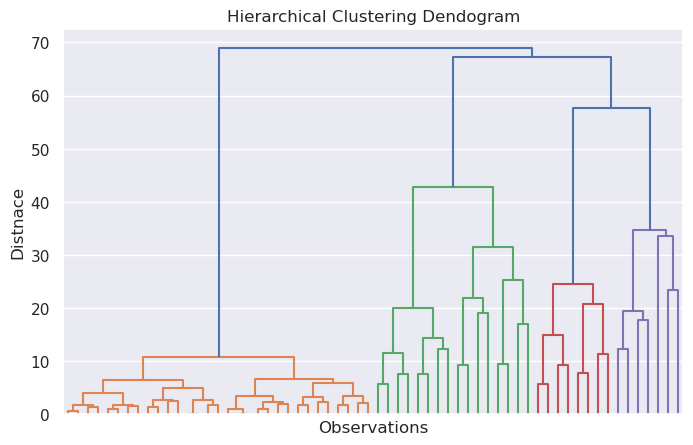

In [19]:
# Create a hierarchical clustering dendrogram
plt.figure(figsize = (8, 5))
plt.title('Hierarchical Clustering Dendogram')
plt.xlabel('Observations')
plt.ylabel('Distnace')
dendrogram(hier_clust,
           truncate_mode = 'level',
           p = 5,
           show_leaf_counts=False,
           no_labels= True)
plt.show()

**Result:** 

The dendrogram shows the distances between the clusters at each level, and the vertical lines represent the merging of clusters. The height of each vertical line represents the distance between the merged clusters. Four groups are displayed as the four terminal branches of the dendrogram, with each group representing a distinct cluster of similar data points. The dendrogram is used to visually identify the optimal number of clusters based on the distance between the clusters and the degree of similarity within each cluster.

## Principal component analysis

In [20]:
# Create an instance of the PCA class that will perform the PCA transformation
pca = PCA()

# Fit the PCA model to the standardized dataset
pca.fit(segmentation_std)

# Calculate the proportion of variance explained by each principal component in the dataset.
pca.explained_variance_ratio_

array([0.25227826, 0.17521555, 0.14252854, 0.13705185, 0.13034599,
       0.08640181, 0.076178  ])

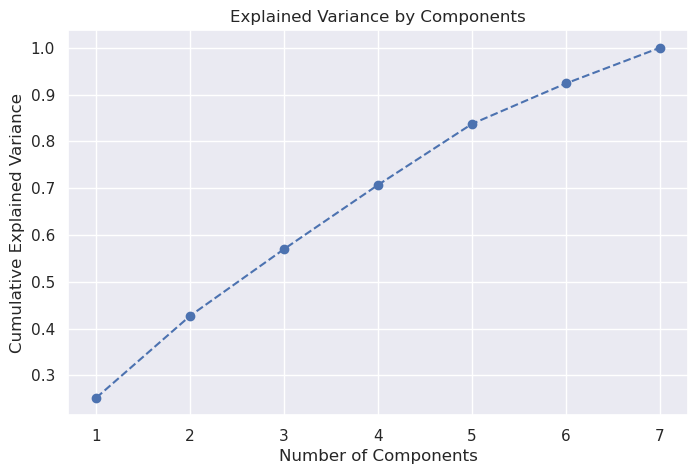

In [21]:
# Plot the cumulative variance explained by total number of components.
plt.figure(figsize = (8, 5))
plt.plot(range(1, 8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

**Result:** 5 principal components are selected since they achieve over 0.8 dumulative explained variance

In [22]:
# Set 5 principal components and then fit the model 
pca = PCA(n_components = 5)
pca.fit(segmentation_std)

PCA(n_components=5)

In [23]:
# Create a pandas DataFrame named df_pca_comp that contains the principal components of the data
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df_segmentation.columns.values,
                           index = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5'])
df_pca_comp

,Age,Education_Binary,Relationship_Status,Income,Kidhome,Teenhome,Recency
Component 1,0.512156,0.308481,0.243509,0.478493,-0.478753,0.353473,0.011686
Component 2,-0.331152,0.004922,-0.348345,0.499821,-0.443537,-0.558448,-0.102764
Component 3,-0.037893,0.034847,-0.058199,0.054630,-0.015180,-0.062767,0.993382
Component 4,0.170961,-0.862706,0.334133,-0.035621,-0.316274,-0.106694,0.046745
Component 5,0.232520,-0.279435,-0.826478,-0.065971,-0.115968,0.408632,-0.002073


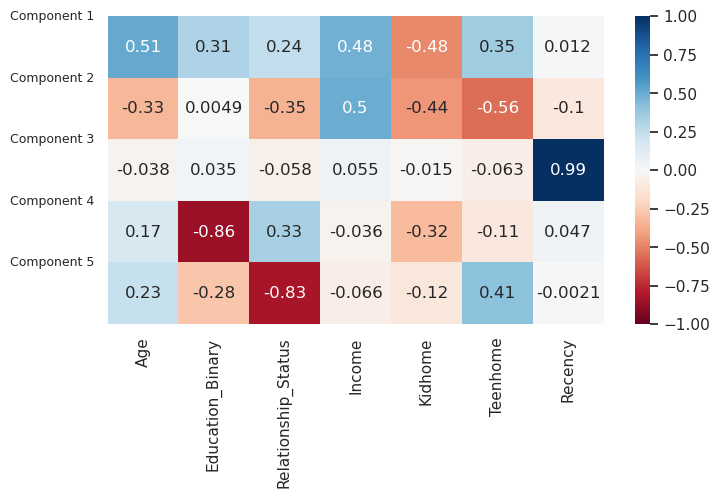

In [24]:
# Create a heatmap of the correlation matrix of the df_pca_comp,
# which relates the principal components to the original features of df_segmentation
plt.figure(figsize = (8, 4))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2, 3, 4], 
           ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5'],
           rotation = 0,
           fontsize = 9)
plt.show()

In [25]:
# Create a new array called scores_pca variable, which contains the 
# transformed data in the new space defined by the principal components
scores_pca = pca.transform(segmentation_std)

In [26]:
# K-means clustering with PCA
# Generate a list of within-cluster sum of squares (WCSS) values for
# K-means clustering models with different numbers of clusters.
# The WCSS values can be used to determine the optimal number of
# clusters to use in the K-means algorithm, based on the elbow method
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

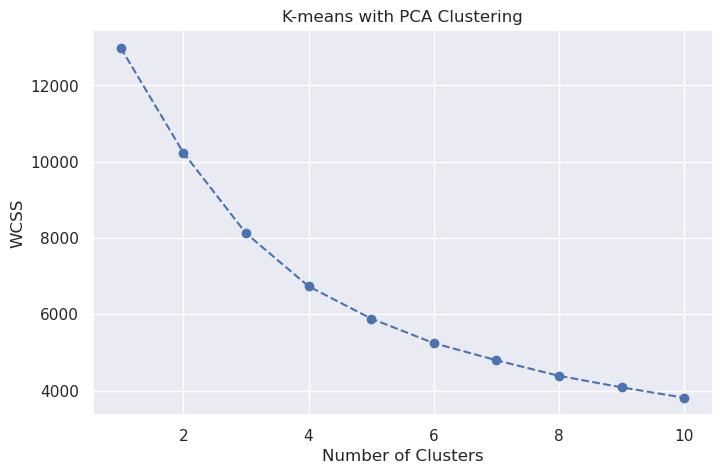

In [27]:
# Visualise the within-cluster sum of squares (WCSS) against the number
# of clusters for a K-means with PCA clustering algorithm
plt.figure(figsize = (8, 5))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

In [28]:
# Initialize an instance of the K-means class from scikit-learn
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)

In [29]:
# Fit the model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [30]:
# Combine two datafames
df_segm_pca_kmeans = pd.concat([df_segmentation.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)

# Rename the columns
df_segm_pca_kmeans.columns.values[-5: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4', 'Component 5']

# The last column we add contains the pca k-means clustering labels
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [31]:
# Visualise the top 5 rows of df_segm_pca_kmeans
df_segm_pca_kmeans.head()

,Age,Education_Binary,Relationship_Status,Income,Kidhome,Teenhome,Recency,Component 1,Component 2,Component 3,Component 4,Component 5,Segment K-means PCA
0,66,1,0,58138.0,0,0,58,0.400222,1.122298,0.440269,-0.061821,1.022078,1
1,69,1,0,46344.0,1,1,38,0.053926,-0.976569,-0.424936,-0.819948,1.647675,3
2,58,1,2,71613.0,0,0,26,0.806800,1.001872,-0.724284,0.446543,-0.880958,1
3,39,1,2,26646.0,1,0,26,-1.752111,-0.192390,-0.790090,-0.350098,-1.347815,0
4,42,1,1,58293.0,1,0,94,-1.247363,0.473133,1.663487,-0.588889,-0.520044,0


In [32]:
# Calculate the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Age,Education_Binary,Relationship_Status,Income,Kidhome,Teenhome,Recency,Component 1,Component 2,Component 3,Component 4,Component 5
Segment K-means PCA,,,,,,,,,,,,
0,46.007194,1.0,1.117986,34774.732374,0.989928,0.247482,49.510791,-1.341618,-0.235051,0.037353,-0.571988,-0.290555
1,52.963287,1.0,1.113636,74984.472028,0.012238,0.103147,49.019231,0.497111,1.330607,0.130329,0.072414,-0.154396
2,45.537037,0.0,1.000000,20306.259259,0.629630,0.092593,48.444444,-3.446970,-0.038201,-0.219988,5.236927,1.613269
3,61.824581,1.0,1.643575,53210.965363,0.279330,0.987709,48.655866,0.932082,-0.665568,-0.099027,0.081918,0.226965


In [33]:
# Calculate the size of each cluster and its proportion to the entire data set
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Age']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename({0:'Average-Income Parents',
                                                          1:'High-Income Seniors',
                                                          2:'Low-Income Parents',
                                                          3:'Senior Parents'})
df_segm_pca_kmeans_freq

,Age,Education_Binary,Relationship_Status,Income,Kidhome,Teenhome,Recency,Component 1,Component 2,Component 3,Component 4,Component 5,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,,,
Average-Income Parents,46.007194,1.0,1.117986,34774.732374,0.989928,0.247482,49.510791,-1.341618,-0.235051,0.037353,-0.571988,-0.290555,695,0.313628
High-Income Seniors,52.963287,1.0,1.113636,74984.472028,0.012238,0.103147,49.019231,0.497111,1.330607,0.130329,0.072414,-0.154396,572,0.258123
Low-Income Parents,45.537037,0.0,1.000000,20306.259259,0.629630,0.092593,48.444444,-3.446970,-0.038201,-0.219988,5.236927,1.613269,54,0.024368
Senior Parents,61.824581,1.0,1.643575,53210.965363,0.279330,0.987709,48.655866,0.932082,-0.665568,-0.099027,0.081918,0.226965,895,0.403881


In [34]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'Average-Income Parents',
                                                          1:'High-Income Seniors',
                                                          2:'Low-Income Parents',
                                                          3:'Senior Parents'})

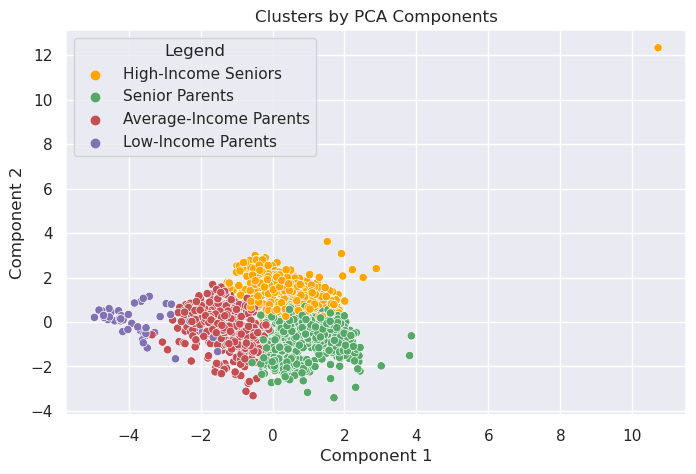

In [35]:
# Create a scatterplot using the first two principal components of a dataset 
# that has been clustered using k-means algorithm. The x-axis corresponds
# to the first principal component, and the y-axis corresponds to the second principal component.  
x_axis = df_segm_pca_kmeans['Component 1']
y_axis = df_segm_pca_kmeans['Component 2']
plt.figure(figsize = (8, 5))
sns.scatterplot(x=x_axis, y=y_axis, hue=df_segm_pca_kmeans['Legend'], palette=['orange', 'g', 'r', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

**Result:** 

Four groups have been identified from two clustering techniques; hierarchical and K-means. The four groups represent: 
1. Average-Income Parents
2. High-Income Seniors
3. Low-Income Parents
4. Senior Parents
